In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import signal as sig
from utils import preprocessing, constants
import matplotlib.pyplot as plt

In [2]:
cwd = Path.cwd()
csv_dir = cwd / "data"
# csv_dir = cwd / "norlab-data"

# Random state
RANDOM_STATE = 21

# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

In [3]:
# Get recordings
terr_dfs = preprocessing.get_recordings(csv_dir, summary)

# Set data partition parameters
NUM_CLASSES = len(np.unique(terr_dfs["imu"].terrain))
N_FOLDS = 5
PART_WINDOW = 5  # seconds
MOVING_WINDOWS = [1.5, 1.6, 1.7, 1.8]  # seconds
# Data augmentation parameters
# 0 < STRIDE < MOVING_WINDOWS
STRIDE = 0.1  # seconds
# If True, balance the classes while augmenting
# If False, imbalance the classes while augmenting
HOMOGENEOUS_AUGMENTATION = True

# Data partition and sample extraction
train, test = preprocessing.partition_data(
    terr_dfs,
    summary,
    PART_WINDOW,
    N_FOLDS,
    random_state=RANDOM_STATE,
)

# Augment data
aug_train, aug_test = preprocessing.augment_data(
    train,
    test,
    summary,
    moving_window=1.5,
    stride=STRIDE,
    homogeneous=HOMOGENEOUS_AUGMENTATION,
)

In [22]:
imu_cols = terr_dfs["imu"].columns.values
pro_cols = terr_dfs["pro"].columns.values

terrains = terr_dfs["imu"].terrain.unique()
terr = terrains[0]

imudat = terr_dfs["imu"]
prodat = terr_dfs["pro"]

imu_mask = (imudat.terrain == terr) & (imudat.run_idx == 1)
imu_exp = imudat[imu_mask]
pro_mask = (prodat.terrain == terr) & (prodat.run_idx == 1)
pro_exp = prodat[pro_mask]

In [5]:
imu_cols.tolist()
pro_cols.tolist()

['time', 'velL', 'velR', 'curL', 'curR', 'terrain', 'run_idx']

In [25]:
data = aug_train[0]

In [16]:
# Time parameters
tw = 0.4
to = 0.2
sens = "imu"

twto = tw - to
sf = summary.sampling_freq.loc[sens]
sens_data = data[sens]

Nwin = int(tw * sf)
win = sig.windows.hamming(Nwin)
hop = int(twto * sf)
SFT = sig.ShortTimeFFT.from_window(win, hop=hop, fs=sf, scale_to="magnitude")

t = imu_exp.time.to_numpy()
x = imu_exp.ay.to_numpy()
# t = pro_exp.time.to_numpy()
# x = pro_exp.velL.to_numpy()
N = len(x)
Sx = SFT.stft(x)

In [18]:
xs = np.vstack([x, x, x, x])
xs.shape
Sxs = SFT.stft(xs, axis=1)
Sx.shape, Sxs.shape, x.shape, xs.shape

((11, 406), (4, 11, 406), (4044,), (4, 4044))

In [21]:
SFT.p_num(x.size), SFT.f.size

(406, 11)

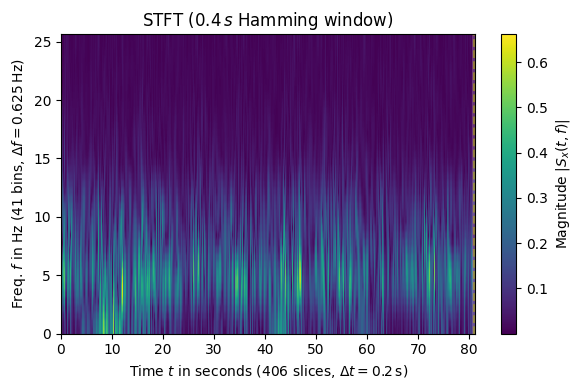

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot

ax.set_title(
    rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hamming window)"
)
ax.set(
    xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, "
    + rf"$\Delta t = {SFT.delta_t:g}\,$s)",
    ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, "
    + rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
    xlim=(t_lo, t_hi),
)

im = ax.imshow(
    abs(Sx),
    origin="lower",
    aspect="auto",
    extent=SFT.extent(N),
    cmap="viridis",
)
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [
    (t_lo, SFT.lower_border_end[0] * SFT.T),
    (SFT.upper_border_begin(N)[0] * SFT.T, t_hi),
]:
    ax.axvspan(t0_, t1_, color="w", linewidth=0, alpha=0.2)

for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax.axvline(t_, color="y", linestyle="--", alpha=0.5)

fig.tight_layout()